In [1]:
from utils.plot.import_library_plot import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tramp.priors import GaussBernouilliPrior, GaussianPrior
from tramp.channels import GaussianChannel, GradientChannel
from tramp.variables import SISOVariable as V, SILeafVariable as O, MILeafVariable, SIMOVariable
from tramp.experiments import TeacherStudentScenario
from tramp.algos import EarlyStoppingEP

# Functions

### Sparse gradient teacher Class

In [2]:
class SparseGradTeacher():
    def __init__(self, size, grad_rho, noise_var):
        self.prior_grad = GaussBernouilliPrior(size=size, rho=grad_rho)
        self.channel = GaussianChannel(var=noise_var)

    def sample(self, seed=None):
        if seed:
            np.random.seed(seed)
        x_prime = self.prior_grad.sample()
        x = x_prime.cumsum()
        x = x - x.mean()
        y = self.channel.sample(x)
        return {"x": x, "x'": x_prime, "y": y}

### Build Sparse gradient Student

In [3]:
def build_sparse_grad_student(size, grad_rho, noise_var):
    x_shape = (size,)
    grad_shape = (1,) + x_shape
    student = (
        GaussianPrior(size=x_shape) @
        SIMOVariable(id="x", n_next=2) @ (
            GaussianChannel(var=noise_var) @ O("y")
            + (
                GradientChannel(shape=x_shape) +
                GaussBernouilliPrior(size=grad_shape, rho=grad_rho)
            ) @ MILeafVariable(id="x'", n_prev=2)
        )
    ).to_model()
    return student

### Plot function

In [4]:
def plot_sparse_gradient(dic, save_fig=False):
    _, axes = plt.subplots(1, 3, figsize=(16, 6))
    cmap = cm.get_cmap('plasma_r')
    tab_col = plt.rcParams['axes.prop_cycle'].by_key()['color']
    tab_l1, tab_l2,  tab_l3 = [], [], []

    l, = axes[0].plot(dic['y'], 'o', color=tab_col[2], label=r'$y$')
    tab_l1.append(l)

    l, = axes[1].plot(dic['x']["x"],
                      color=tab_col[0], label=r'$x^*$')
    tab_l2.append(l)
    l, = axes[1].plot(dic['x_pred']["x"],
                      color=tab_col[1], label=r'$\hat{x}$')
    tab_l2.append(l)

    l, = axes[2].plot(dic['x']["x'"].ravel(),
                      color=tab_col[0], label=r"$z^*$")
    tab_l3.append(l)
    l, = axes[2].plot(dic['x_pred']["x'"].ravel(),
                      color=tab_col[1], label=r"$\hat{z}$")
    tab_l3.append(l)

    """ Titles  """
    axes[0].set_title(r'$y$')
    axes[1].set_title(r'$x$')
    axes[2].set_title(r'$z = \nabla x$')

    """ Ticks   """
    axes[0].set_xlim([0, dic['N']])
    axes[1].set_xlim([0, dic['N']])
    axes[2].set_xlim([0, dic['N']])

    axes[1].legend(tab_l2, [l.get_label() for l in tab_l2], loc='lower center', fancybox=True,
                   shadow=False, ncol=1)
    axes[0].legend(tab_l1, [l.get_label() for l in tab_l1], loc='lower center', fancybox=True,
                   shadow=False, ncol=1)
    axes[2].legend(tab_l3, [l.get_label() for l in tab_l3], loc='lower center', fancybox=True,
                   shadow=False, ncol=1)

    """ Save   """
    if save_fig:
        dir_fig = 'Figures/'
        os.makedirs(dir_fig) if not os.path.exists(dir_fig) else 0
        file_name = f'{dir_fig}{dic["model"]}_N={dic["N"]}_rho={str(dic["rho"]).replace(".","")}_seed={dic["seed"]}.pdf'

        plt.tight_layout()
        plt.savefig(file_name, format='pdf', dpi=1000,
                    bbox_inches="tight", pad_inches=0.1)

    """ Show   """
    plt.show()

# Experiment

### Parameters

In [5]:
## Parameters ##
# Size #
N = 400
# Sparsity #
rho = 0.04
# Seed #
seed = 1

### Build model

In [6]:
## Build the teacher ##
teacher = SparseGradTeacher(size=N, grad_rho=rho, noise_var=1e-2)

## Build the student ##
student = build_sparse_grad_student(size=N, grad_rho=rho, noise_var=1e-2)

## Create a Teacher Student Scenario ##
# Variables to track #
x_ids = ["x", "x'"] 
scenario = TeacherStudentScenario(teacher, student, x_ids=x_ids)
scenario.setup(seed=seed)

### Run TRAMP EP

In [7]:
## Run EP ##
# Max number of EP iterations #
max_iter = 1000
# Damping value #
damping = 0.1
scenario.run_ep(max_iter=max_iter, 
                    damping=damping,
                    callback=EarlyStoppingEP(tol=1e-2)
                    )

dic = {'model': 'sparse_gradient', 'N': N, 'rho': rho, 'seed': seed,
       'y': scenario.observations["y"], 'x': scenario.x_true, 'x_pred': scenario.x_pred}

### Plot

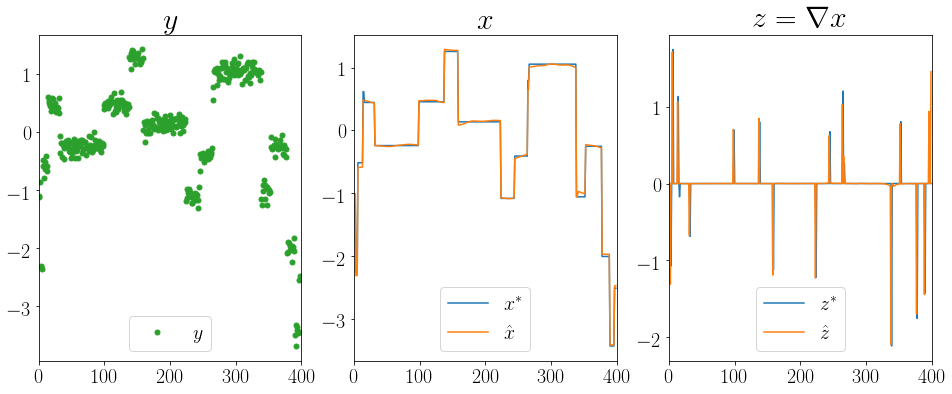

In [8]:
plot_sparse_gradient(dic, save_fig=False)